In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


# Load CIFAR-10 Dataset

### **CIFAR-10 Dataset**: It consists of 60,000 32x32 color images in 10 classes. Here, only the training set (X_train) is used, and the images are normalized to values between 0 and 1 to improve training stability.

In [28]:
# Load CIFAR-10 dataset
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]


# Build Generator

### The **generator** creates images that resemble real data from a random noise vector (input_dim=100), also called a latent space. It uses Convolutional Transpose layers (also known as deconvolution or upsampling layers) to gradually increase the spatial dimensions and convert the input noise into a 32x32 RGB image.

### ***Dense(256 * 8 * 8)***: The noise vector is transformed into a 256-channel feature map of shape 8x8.

### ***Reshape((8, 8, 256))***: Reshapes the dense output into a 3D feature map.

### ***Conv2DTranspose***: These layers upsample the feature maps to 16x16 and 32x32. Strides of 2 are used to double the spatial dimensions.

### ***Conv2D(3)***: The output is a 32x32 image with 3 channels (RGB). Tanh activation scales the pixel values to the range [-1, 1] to match the normalized CIFAR-10 images.

In [29]:
# Generator model (DCGAN)
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 256, input_dim=100))  # Start from a low-dimensional space
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # Output (16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # Output (32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # Output (32, 32, 3)

    return model

generator = build_generator()
generator.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16384)             1654784   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_300 (Ba  (None, 8, 8, 256)        1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 16, 16, 128)      524416    
 Transpose)                                                      
                                                                 
 batch_normalization_301 (Ba  (None, 16, 16, 128)    

# Building the Discriminator

### The **discriminator** tries to differientiate between real and generated (fake) images. It outputs a probability between 0 (fake) and 1 (real) using a sigmoid activation.

### ***Conv2D(64)***: Applies convolution with a kernel size of 5 and a stride of 2 to downsample the 32x32 image to 16x16.

### ***LeakyReLU(0.2)***: An activation function similar to ReLU, but with a small slope for negative values (alpha = 0.2). This prevents neurons from dying during training (which can happen with ReLU).

### ***Conv2D(128)***: Further downsampling the feature map from 16x16 to 8x8.

### ***Flatten()***: Converts the 3D feature maps into a 1D vector for the dense output layer.

### ***Dense(1, sigmoid)***: Produces a single output between 0 and 1 representing whether the input image is real or fake.

In [30]:
# Discriminator model (DCGAN)
def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Call the discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_306 (Conv2D)         (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_307 (Conv2D)         (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_308 (Conv2D)         (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_309 (Conv2D)         (None, 2, 2, 512)       

# Compile the Models

### The ***discriminator is compiled with the binary cross-entropy loss function since it performs binary classification*** (real vs. fake). The Adam optimizer is used to optimize the model.

In [31]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')


# Train the function

### ***Noise Generation***: A batch of random noise vectors is generated and passed through the generator to produce fake images.

### ***Discriminator Training***: The discriminator is trained on both real and fake images. The real images are labeled as 0.9 (soft label, slightly less than 1 to prevent overconfidence), and the fake images are labeled as 0. Both are concatenated into one batch.

### ***Generator Training***: The generator tries to fool the discriminator, so it’s trained with the goal that the discriminator labels the generated images as real (1). During this phase, the discriminator's weights are frozen (discriminator.trainable = False).

### ***Loss Calculation***: After each epoch, the losses of both the discriminator (d_loss) and generator (g_loss) are printed.

In [32]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)


# Image Generation Function

### This function generates images from random noise using the generator and plots them in a grid using Matplotlib. The images are rescaled from the [-1, 1] range (from the tanh activation) back to [0, 1] for viewing.

2/2 [==============================] - 1s 200ms/step
0 [D loss: 0.6913726925849915, acc.: 42.96875%] [G loss: 0.46794405579566956]
1/1 [==============================] - 1s 535ms/step


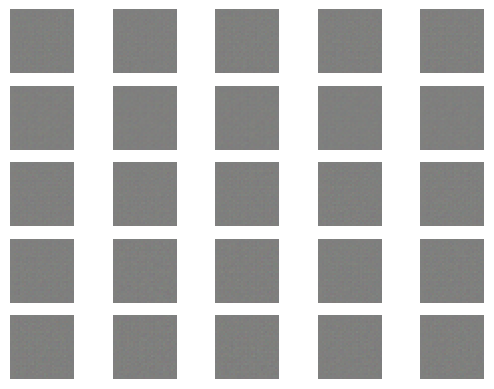

2/2 [==============================] - 0s 166ms/step


2/2 [==============================] - 1s 370ms/step


2/2 [==============================] - 1s 279ms/step


2/2 [==============================] - 0s 142ms/step


2/2 [==============================] - 0s 132ms/step


2/2 [==============================] - 0s 149ms/step


2/2 [==============================] - 0s 165ms/step


In [33]:
# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the DCGAN
train(epochs=1000, batch_size=64, save_interval=1000)


In [34]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.stats import entropy

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Resize and preprocess images for InceptionV3
def resize_images(images, target_size=(299, 299)):
    resized_images = []
    for img in images:
        resized_img = resize(img, target_size)  # Resize each image
        resized_images.append(resized_img)
    resized_images = np.array(resized_images)
    return preprocess_input(resized_images)  # Preprocess for InceptionV3

# Function to calculate Inception Score
def calculate_inception_score(images, model, n_split=10):
    # Resize images to 299x299 for InceptionV3
    images_resized = resize_images(images, target_size=(299, 299))

    # Generate predictions from the Inception model
    preds = model.predict(images_resized)

    # Split the predictions into subsets for IS calculation
    scores = []
    for i in range(n_split):
        split_scores = preds[i * (len(preds) // n_split):(i + 1) * (len(preds) // n_split)]
        p_y = np.mean(split_scores, axis=0)
        score = np.exp(np.mean(entropy(split_scores.T, p_y)))
        scores.append(score)
    
    return np.mean(scores), np.std(scores)
